Prototype iteration tbd

# Topic Prototyping

Prototype code for Topic Modeling of Posts using an enhanced tokenizer. Objective is to find the best topic model for this data by scoring.

In [33]:
import os, sys, re, string, pickle, random
sys.path.append("..")
from config import credentials
import dropbox

import numpy as np
import pandas as pd

import spacy

from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from joblib import dump, load

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
random_state = 23
random.seed(random_state)

## Loading

In [29]:
data_path = "/Data/CSVData"
model_path = "../models"
figures_path = "../reports/figures/"

In [10]:
team_dbx = dropbox.DropboxTeam(credentials.dropbox_team_access_token)
team_root = team_dbx.with_path_root(dropbox.common.PathRoot.namespace_id(
    credentials.dropbox_team_namespace_id))
user_dbx = team_root.as_user(credentials.dropbox_team_member_id)

posts_fpath = os.path.join(data_path, "PolPosts.csv")
_, res_posts = user_dbx.files_download(posts_fpath)

raw_posts = pd.read_csv(res_posts.raw)
print("Posts", raw_posts.shape)

Posts (27204, 23)


## Preprocessing

Dataset cleansing

In [11]:
# Remove unnecessary cols and rename them uniformly
posts_cols = raw_posts.columns.to_list()
posts_cols.remove("text")
posts_cols.remove("textID") # keep these cols
raw_posts.drop(posts_cols, axis=1, inplace=True)
raw_posts.columns = ["text", "textID"]

corpus = raw_posts.copy()

# Remove empty texts
corpus.text.replace("", np.nan, inplace=True)
corpus.dropna(subset=["text"], inplace=True)
corpus = corpus[~corpus.text.str.isspace()]

# Remove duplicated texts
corpus.drop_duplicates(subset=["text"], keep="first", inplace=True)

corpus.shape

(22534, 2)

## Topic Modeling

TFIDF + LDA

In [15]:
data = corpus.copy()

### Vectorizer

In [18]:
from spacy_tokenize import topic_tokenizer2 # topic_tokenizer + del @[USER] + del engl stopwords

tfidf = TfidfVectorizer(lowercase=True, tokenizer=topic_tokenizer2, max_features=40000) # total tokens 43214
tfidf_v = tfidf.fit_transform(data.text)

In [20]:
#len(tfidf.vocabulary_)

### Model

In [21]:
lda = LatentDirichletAllocation(n_jobs=1, random_state=random_state, verbose=10)

Parameter Tuning

In [22]:
lda_params = {"n_components": [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]}

gs = GridSearchCV(lda, param_grid=lda_params, n_jobs=6, pre_dispatch="2*n_jobs", verbose=10, cv=3)
gs.fit(tfidf_v)

Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   22.4s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   41.7s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  3.2min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  4.7min
[Parallel(n_jobs=6)]: Done  46 out of  51 | elapsed:  5.7min remaining:   37.3s
[Parallel(n_jobs=6)]: Done  51 out of  51 | elapsed:  6.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 1 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 2 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 3 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 4 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 5 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 6 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 7 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 8 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 9 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 10 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=1,
                                                 perp_tol=0.1, random_state=23,
                                                 topic_word_prior=None,
                                                 total_samples=1000000.0,
                    

Fit best model - attention, will be the one with least components (because of scorer)

In [23]:
model = gs.best_estimator_
print(gs.best_params_)

{'n_components': 20}


Log Likelihood of gridsearched models

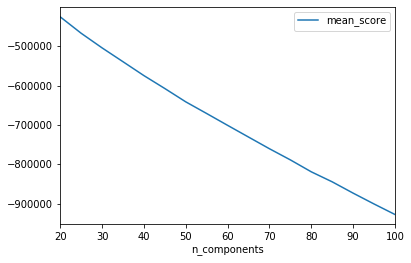

In [24]:
gs_results = gs.cv_results_

n_comps = gs_results["param_n_components"].data
scores = gs_results["mean_test_score"]

gs_eval = pd.DataFrame({"n_components": n_comps, "mean_score": scores}).set_index("n_components")
gs_eval.plot(kind="line")

Models for visual inspection

In [27]:
models = {
    "lda_20_t2": LatentDirichletAllocation(n_components=20, n_jobs=1, random_state=random_state, verbose=1),
    "lda_25_t2": LatentDirichletAllocation(n_components=25, n_jobs=1, random_state=random_state, verbose=1),
    "lda_30_t2": LatentDirichletAllocation(n_components=30, n_jobs=1, random_state=random_state, verbose=1),
    "lda_35_t2": LatentDirichletAllocation(n_components=35, n_jobs=1, random_state=random_state, verbose=1),
    "lda_40_t2": LatentDirichletAllocation(n_components=40, n_jobs=1, random_state=random_state, verbose=1),
    "lda_45_t2": LatentDirichletAllocation(n_components=45, n_jobs=1, random_state=random_state, verbose=1),
    "lda_50_t2": LatentDirichletAllocation(n_components=50, n_jobs=1, random_state=random_state, verbose=1),
    "lda_55_t2": LatentDirichletAllocation(n_components=55, n_jobs=1, random_state=random_state, verbose=1)
}

In [32]:
lda_path = os.path.join(model_path, "topic_lda")

for model in models:
    print("Fitting", model)
    models[model].fit(tfidf_v)
    print("Dump", model, "\n")
    dump(models[model], os.path.join(lda_path, model + ".joblib"))

Fitting lda_20_t2
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
Dump lda_20_t2 

Fitting lda_25_t2
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
Dump lda_25_t2 

Fitting lda_30_t2
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
Dump lda_30_t2 

Fitting lda_35_t2
iter

In [34]:
def print_scores(model, name):
    """ Prints Log-Likelihood and Perplexity scores of model. """
    print("Scores for", name)
    print("Log Likelihood:", model.score(tfidf_v))
    print("Perplexity:", model.perplexity(tfidf_v), "\n")
    
    
for model in models:
    print_scores(models[model], model)

Scores for lda_20_t2
Log Likelihood: -823769.4428793517
Perplexity: 439392.6958116524 

Scores for lda_25_t2
Log Likelihood: -850380.1403143142
Perplexity: 668555.0123394085 

Scores for lda_30_t2
Log Likelihood: -872412.5615854712
Perplexity: 946368.1043632928 

Scores for lda_35_t2
Log Likelihood: -890179.4457267278
Perplexity: 1252460.2303607597 

Scores for lda_40_t2
Log Likelihood: -907469.6480081885
Perplexity: 1645138.6475968717 

Scores for lda_45_t2
Log Likelihood: -924594.6542328472
Perplexity: 2155308.62030232 

Scores for lda_50_t2
Log Likelihood: -939106.2492230071
Perplexity: 2709657.8637919957 

Scores for lda_55_t2
Log Likelihood: -953639.240104377
Perplexity: 3407736.55240859 



In [35]:
viz_path = os.path.join(figures_path, "topics")

for model in models:
        p = None
        p = pyLDAvis.sklearn.prepare(models[model], tfidf_v, tfidf, mds="tsne")
        pyLDAvis.save_html(p, os.path.join(viz_path, "topics_" + model + ".html"))
        print("topics_" + model + " persisted")

/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


topics_lda_20_t2 persisted


/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


topics_lda_25_t2 persisted


/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


topics_lda_30_t2 persisted


/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


topics_lda_35_t2 persisted


/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


topics_lda_40_t2 persisted


/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


topics_lda_45_t2 persisted


/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


topics_lda_50_t2 persisted


/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


topics_lda_55_t2 persisted


# Conclusion

A scoring approach for finding the optimal number of topics in the model isn't helpful in this case (pretty linear decay of Log Likelihood with increasing n_components). Therefore a qualitative interpretation of the most promising candidates (n_components = \[20, 25, 30, 40, 50, 80, 100\]) will be done in the next iteration.